## Requirements
conda install conda-forge::mujoco-python

## Imports

In [1]:
%matplotlib widget

# Set up GPU rendering.
import os

# Check if Mujoco is working.
try:
  print('Checking that Mujoco works:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong with Mujoco')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

from simple_pid import PID
from scipy.spatial.transform import Rotation

import cv2

def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

ModuleNotFoundError: No module named 'ipympl'

## Path planner

[[0, 1, 0, 1, 0], [0, 0, 1, 1, 0], [0.1, 0.1, 0.1, 0.1, 0]]


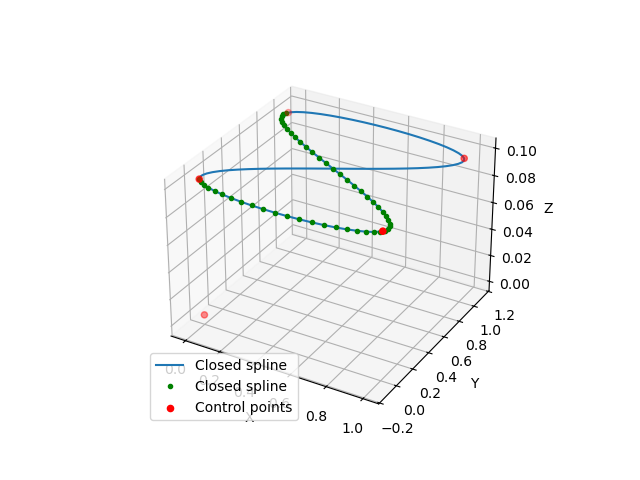

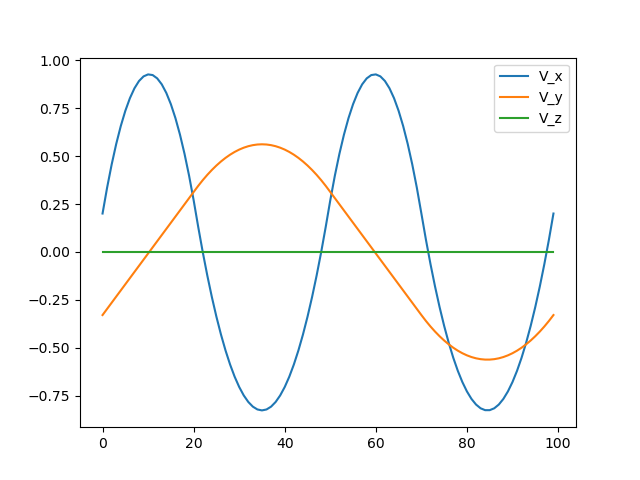

In [2]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

# Define control points for a closed loop
# theta = np.linspace(0, 2*np.pi, 8, endpoint=False)
# x = np.cos(theta) + 0.1 * np.random.randn(8)
# y = np.sin(theta) + 0.1 * np.random.randn(8)
# z = np.sin(2*theta) + 0.1 * np.random.randn(8)

x = [0, 1, 0, 1, 0]
y = [0, 0, 1, 1, 0]
z = [0.1, 0.1, 0.1, 0.1, 0]

def spline_path(x,y,z):
    # Create a periodic spline
    print([x, y, z])
    tck, u = interpolate.splprep([x, y, z], s=0, per=True)

    # Generate points on the spline
    u_new = np.linspace(0, 1, 100)
    x_new, y_new, z_new = interpolate.splev(u_new, tck)
    vx, vy, vz = interpolate.splev(u_new, tck, der=1)

    v = np.sqrt(vx**2 + vy**2 + vz**2)
    v_max = np.max(v)

    return x_new, y_new, z_new, vx/v_max, vy/v_max, vz/v_max

x_new, y_new, z_new, vx, vy, vz = spline_path(x,y,z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_new, y_new, z_new, label='Closed spline')
ax.plot(x_new[0:len(x_new)//2], y_new[0:len(x_new)//2], z_new[0:len(x_new)//2],'g.', label='Closed spline')
ax.scatter(x, y, z, c='red', label='Control points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

plt.figure()
plt.plot(vx, label='V_x')
plt.plot(vy, label='V_y')
plt.plot(vz, label='V_z')
plt.legend()
plt.show()

## Path planner with velocity constraints:
## NOT WORKING YET (DON'T RUN)

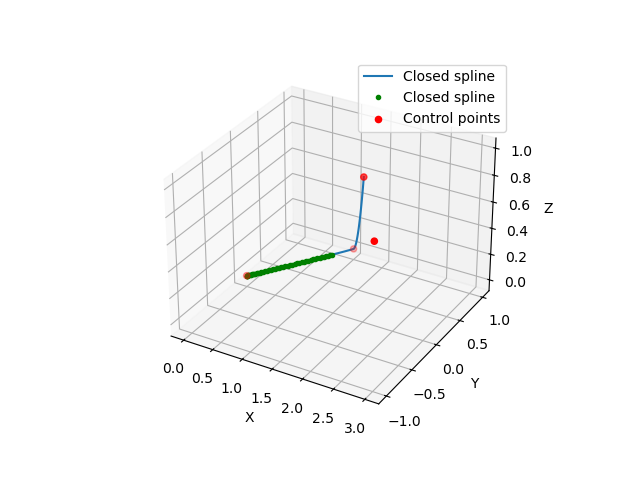

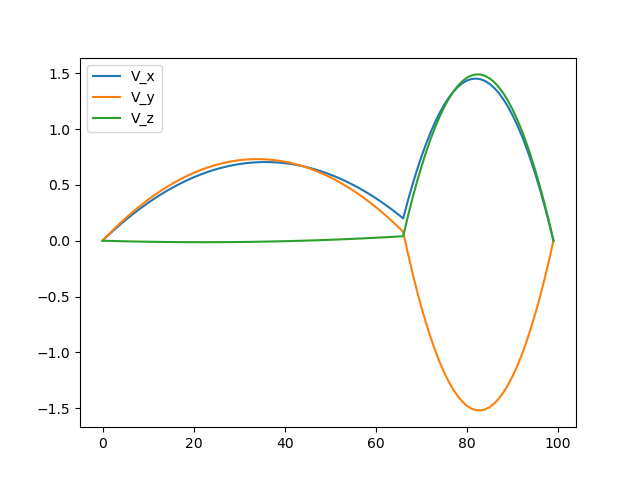

In [32]:
from scipy.interpolate import CubicHermiteSpline
import numpy as np

def spline_path_constrained(t, x, y, z, vx, vy, vz):
    # Create splines with velocity constraints
    sx = CubicHermiteSpline(t, x, vx)
    sy = CubicHermiteSpline(t, y, vy)
    sz = CubicHermiteSpline(t, z, vz)

    # Evaluate spline at intermediate times
    t_new = np.linspace(0, 3, 100)
    x_new = sx(t_new)
    y_new = sy(t_new)
    z_new = sz(t_new)
    vx_new = sx(t_new, 1)   # derivative = velocity
    vy_new = sy(t_new, 1)
    vz_new = sz(t_new, 1)
    return x_new, y_new, z_new, vx_new, vy_new, vz_new

# Example waypoints
t = np.array([0, 2, 3, 4])         # parameter, e.g., time
x = np.array([0, 1, 2, 3])
y = np.array([0, 1, 0, -1])
z = np.array([0, 0, 1, 1])

# Desired velocities at waypoints
vx = np.array([0, 0.2, 0, -0.5])
vy = np.array([0, 0.08, 0, -0.2])
vz = np.array([0, 0.04, 0, 0])

x_new, y_new, z_new, vx, vy, vz = spline_path_constrained(t, x, y, z, vx, vy, vz)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_new, y_new, z_new, label='Closed spline')
ax.plot(x_new[0:len(x_new)//2], y_new[0:len(x_new)//2], z_new[0:len(x_new)//2],'g.', label='Closed spline')
ax.scatter(x, y, z, c='red', label='Control points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

plt.figure()
plt.plot(vx, label='V_x')
plt.plot(vy, label='V_y')
plt.plot(vz, label='V_z')
plt.legend()
plt.show()


## Drone simulation
### Simple path tracker
This method involves the following steps:
1. Collect positions of gates as control points
2. Spline path generation based on these control points
3. Division of path with additional waypoints placed at even intervals 
4. Then in a loop until the last waypoint is reached: set position hold to next waypoint until satisfactory position error with feedforward velocity set to the spline velocity at that waypoint (K_ff gain is scaled by position error and capped at 1)

In [3]:
# Get MuJoCo's standard humanoid model.
dir_path = os.getcwd()

MAX_MOTOR_THRUST = 6.0
MIN_MOTOR_THRUST = 0.0

class CtrlType:
  SINUSOID = 0
  ATT_RATE = 1
  ATT_HOLD = 2
  VEL_HOLD = 3
  POS_HOLD = 4
  FOLLOW_SPLINE = 5

def _wrap_angle_error(angle_error):
  if angle_error > np.pi:
    return angle_error - 2 * np.pi
  elif angle_error < -np.pi:
    return angle_error + 2 * np.pi
  else:
    return angle_error

def sqrt_controller(Kp, error):
      if abs(error) < 30/180 * np.pi:
        # Square root region
        return np.sign(error) * np.sqrt(Kp*abs(error))
      else:
        return Kp*error

class Drone:
  def __init__(self, xml_path, n_gates=0):
    # Load the model, make two MjData's.
    self.model = mujoco.MjModel.from_xml_path(xml_path)
    self.data = mujoco.MjData(self.model)
    self.model.opt.enableflags |= mujoco.mjtEnableBit.mjENBL_ENERGY

    self.mass = 1.325 # change this if using different model

    # Rate controller PIDs
    self.pid_thrust = PID(5, 0.5, 0.01, setpoint=0)
    self.pid_roll_rate = PID(1, 0.5, 0.01, setpoint=0, output_limits= (-1,1))
    self.pid_pitch_rate = PID(1, 0.5, 0.01, setpoint=0, output_limits= (-1,1))
    self.pid_yaw_rate = PID(5, 0.5, 0.01, setpoint=0, output_limits= (-1,1))

    # Attitude controller PIDs
    self.pid_alt = PID(1, 0, 0, setpoint=0, output_limits= (-1,1))
    self.Kp = 2
    self.Kp_yaw = 1
    # Unused - using SQRT controller instead
    # self.pid_roll = PID(3, 2, 5, setpoint=0, output_limits= (-1,1))
    # self.pid_pitch = PID(3, 2, 5, setpoint=0, output_limits= (-1,1))
    # self.pid_yaw = PID(5, 1, 5, setpoint=0, output_limits= (-1,1))

    # Velocity XY controller PIDs
    self.pid_vx = PID(10, 0.2, 3, setpoint=0, output_limits= (-10,10))
    self.pid_vy = PID(10, 0.2, 3, setpoint=0, output_limits= (-10,10))

    self.Kp_pos = 1

    # Arrays for data
    self.t_vec = []
    self.x_hist = []
    self.y_hist = []
    self.z_hist = []
    self.vx_hist = []
    self.vy_hist = []
    self.vz_hist = []
    self.wx_hist = []
    self.wy_hist = []
    self.wz_hist = []
    self.energy = [] # Track simulation time-step energy loss

    self.pitch_hist = []
    self.roll_hist = []
    self.yaw_hist = []
    self.target_pitch_hist = []
    self.target_roll_hist = []
    self.target_yaw_hist = []
    self.pitch_error_hist = []
    self.roll_error_hist = []
    self.yaw_error_hist = []

    self.target_roll_rate_hist = []
    self.target_pitch_rate_hist = []
    self.target_yaw_rate_hist = []

    self.vx_error_hist = []
    self.vy_error_hist = []

    self.target_x_hist = []
    self.target_y_hist = []
    self.target_z_hist = []

    # Gate positions
    mujoco.mj_forward(self.model, self.data)
    self.n_gates = n_gates
    self.gate_centres = []
    self.control_points = [[self.data.qpos[0],self.data.qpos[1],self.data.qpos[2]]]
    self.gate_d = 0.5

    for i in range(self.n_gates):
      pos = self.data.xpos[mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, "gate"+str(i+1))]   # numpy array [x, y, z]
      pos[2] += 0.8 # gate position in xml file corresponds to base, shift up 0.8 for gate centre
      print(f"Gate {i+1} position: {pos}")

      # Also add waypoints in front and behind of gate
      quat = self.data.xquat[mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, "gate"+str(i+1))]
      euler_gate = Rotation.from_quat(quat).as_euler('zyx',degrees=False)
      # print(euler_gate)

      yaw = euler_gate[2]
      pos1 = pos - self.gate_d * np.array([np.sin(yaw), np.cos(yaw), 0])
      pos2 = pos + self.gate_d * np.array([np.sin(yaw), np.cos(yaw), 0])
      self.control_points.append(pos1)
      self.gate_centres.append(pos)
      self.control_points.append(pos)
      self.control_points.append(pos2)

      # For spline calculation
    self.control_points.append([0,0,0])

    points_x = []
    points_y = []
    points_z = []
    for i in range(len(self.control_points)):
      points_x.append(self.control_points[i][0])
      points_y.append(self.control_points[i][1])
      points_z.append(self.control_points[i][2])
    
    # Compute path
    self.spline_x, self.spline_y, self.spline_z, self.spline_vx, self.spline_vy, self.spline_vz = spline_path(points_x,points_y,points_z)
    self.spline_idx = 0
    

  def get_position(self):
    return self.data.qpos # (x y z q1 q2 q3 q4)

  def get_velocities(self):
    return self.data.qvel # (vx vy vz wx wy wz)

  def reset_sim(self):
    # Set drone to hover
    mujoco.mj_resetDataKeyframe(self.model, self.data, 0)

  def ctrl_sinusoid(self, duration):
    self.data.ctrl = np.array([0.31, 0.31, 0.31, 0.31]) * np.sin(2*np.pi*2*self.data.time/duration) + np.array([3.04, 3.44, 3.04, 3.44])
    # self.data.ctrl = np.array([0.31, 0.31, 0.31, 0.31]) * np.sin(2*np.pi*2*self.data.time/duration) + np.array([3.44, 3.44, 3.04, 3.04])
    
    # ctrl is [motor1 motor2 motor3 motor4] where motor1 is front left, and they are numbered clockwise
    # M1/M3 are CCW (-ve yaw) and M2/M4 are CW (+ve yaw)

  def _rates_to_motor(thrust, roll_rate, pitch_rate, yaw_rate):
    return np.array([
      thrust + roll_rate + pitch_rate - yaw_rate,
      thrust - roll_rate + pitch_rate + yaw_rate,
      thrust - roll_rate - pitch_rate - yaw_rate,
      thrust + roll_rate - pitch_rate + yaw_rate
    ])

  def ctrl_att_rate(self, target_vz, target_roll_rate, target_pitch_rate, target_yaw_rate):

    self.pid_thrust.setpoint = target_vz
    self.pid_roll_rate.setpoint = target_roll_rate
    self.pid_pitch_rate.setpoint = target_pitch_rate
    self.pid_yaw_rate.setpoint = target_yaw_rate

    self.target_roll_rate_hist.append(target_roll_rate)
    self.target_pitch_rate_hist.append(target_pitch_rate)
    self.target_yaw_rate_hist.append(target_yaw_rate)

    self.data.ctrl = Drone._rates_to_motor(self.pid_thrust(self.vz) + 3.249,
                                           self.pid_roll_rate(self.roll_rate),
                                           self.pid_pitch_rate(self.pitch_rate),
                                           self.pid_yaw_rate(self.yaw_rate))

  def ctrl_att_hold(self, target_roll, target_pitch, target_yaw, target_vz=0):

    # Store target attitudes
    self.target_roll_hist.append(target_roll)
    self.target_pitch_hist.append(target_pitch)
    self.target_yaw_hist.append(target_yaw)
    
    # self.pid_alt.setpoint = target_alt
    # self.pid_roll.setpoint = target_roll
    # self.pid_pitch.setpoint = target_pitch
    # self.pid_yaw.setpoint = target_yaw

    r2 = Rotation.from_euler('zyx', np.array([target_roll, target_pitch, target_yaw]), degrees=False)

    rot = r2 * self.r1.inv() # to get relative rotation between attitude and target in the world frame
    euler_error = rot.as_euler('zyx', degrees=False)
    roll_error = _wrap_angle_error(euler_error[0])
    pitch_error = _wrap_angle_error(euler_error[1])
    yaw_error = _wrap_angle_error(euler_error[2])
    # Store attitude errors
    self.roll_error_hist.append(roll_error)
    self.pitch_error_hist.append(pitch_error)
    self.yaw_error_hist.append(yaw_error)

    # P control
    # target_rise_rate = self.pid_alt(self.altitude)
    # target_roll_rate_world = self.pid_roll(self.roll)
    # target_pitch_rate_world = self.pid_pitch(self.pitch)
    # target_yaw_rate_world = self.pid_yaw(self.yaw)
      
    target_roll_rate_world = -sqrt_controller(self.Kp, roll_error)
    target_pitch_rate_world = -sqrt_controller(self.Kp, pitch_error)
    target_yaw_rate_world = sqrt_controller(self.Kp_yaw, yaw_error)

    # Transform to body frame
    target_p= target_roll_rate_world - np.sin(self.pitch) * target_yaw_rate_world
    target_q = np.cos(self.roll) * target_pitch_rate_world + np.sin(self.roll) * np.cos(self.pitch) * target_yaw_rate_world
    target_r = -np.sin(self.roll) * target_pitch_rate_world + np.cos(self.pitch) * np.cos(self.roll) * target_yaw_rate_world

    # self.ctrl_att_rate(target_rise_rate, target_p, target_q, target_r)
    self.ctrl_att_rate(target_vz, target_roll_rate_world, target_pitch_rate_world, target_yaw_rate_world)
  
  def ctrl_vel(self, target_vx, target_vy, target_vz):
    g = 9.8
    vx_error = target_vx - self.vx
    vy_error = target_vy - self.vy

    self.vx_error_hist.append(vx_error)
    self.vy_error_hist.append(vy_error)

    # Kp_vel = 5
    # target_pitch = Kp_vel * np.arctan(vx_error/g)
    # target_roll = Kp_vel * np.arctan(np.cos(target_pitch)*vy_error/g)

    self.pid_vx.setpoint = target_vx
    self.pid_vy.setpoint = target_vy
    target_ax = self.pid_vx(self.vx)
    target_ay = self.pid_vy(self.vy)
    target_pitch = np.arctan(target_ax/g)
    target_roll = np.arctan(np.cos(target_pitch)*target_ay/g)

    # print(f'Attitude hold {target_roll}, {target_pitch}, 0, {target_vz}')
    self.ctrl_att_hold( target_roll, target_pitch, np.pi, target_vz=target_vz)
    return
  
  def ctrl_pos_hold(self, x, y, z, ff_vx=0, ff_vy=0, ff_vz=0):
    x_error = self.x - x
    y_error = self.y - y
    z_error = self.z - z

    self.target_x_hist.append(x)
    self.target_y_hist.append(y)
    self.target_z_hist.append(z)

    target_vx = -sqrt_controller(self.Kp_pos, x_error)
    target_vy = -sqrt_controller(self.Kp_pos, y_error)
    target_vz = -sqrt_controller(self.Kp_pos, z_error)
    # print(f'Target v: {[target_vx, target_vy, target_vz]}')
    # print(f'Feedforward v: {[ff_vx, ff_vy, ff_vz]}')

    self.ctrl_vel(target_vx + ff_vx, target_vy + ff_vy, target_vz+ff_vz)
    return
  
  def follow_spline(self,spline_step=1, wp_error = 0.1):
    # Increment spline index if close enough to next waypoint
    idx = self.spline_idx%len(self.spline_x)
    next_waypoint = [self.spline_x[idx], self.spline_y[idx], self.spline_z[idx]]
    pos_error = np.sqrt( (self.x-next_waypoint[0])**2 + (self.y-next_waypoint[1])**2 + (self.z-next_waypoint[2])**2)
    if pos_error < wp_error:
      self.spline_idx += spline_step
      # print(f'Idx = {self.spline_idx}')

    # Set position hold to waypoint with feedforward velocity scaled by position error
    idx = self.spline_idx%len(self.spline_x)
    next_waypoint = [self.spline_x[idx], self.spline_y[idx], self.spline_z[idx]]
    pos_error = np.sqrt( (self.x-next_waypoint[0])**2 + (self.y-next_waypoint[1])**2 + (self.z-next_waypoint[2])**2)
    K_ff = 5 * np.min([wp_error/pos_error, 1])
    self.ctrl_pos_hold(next_waypoint[0], next_waypoint[1], next_waypoint[2], ff_vx=K_ff * self.spline_vx[idx], ff_vy=K_ff * self.spline_vy[idx], ff_vz=K_ff * self.spline_vz[idx])
    
    
    return


  def run_sim(self, sim_duration, sim_framerate, ctrl_type=CtrlType.SINUSOID, enable_camera=False):
    # Episode parameters.
    duration = sim_duration   # (seconds)
    framerate = sim_framerate # (Hz)
    n_steps = duration * framerate
    self.model.opt.timestep = 1/framerate

    # Make a camera.
    cam = mujoco.MjvCamera()
    mujoco.mjv_defaultCamera(cam)
    cam.distance = 20.0
    cam.azimuth = 260
    cam.elevation = -60

    
    self.reset_sim()

    # Simulate and render.
    frames = []
    frames_drone = []
    renderer = mujoco.Renderer(self.model, 480, 640)
    if enable_camera:
      renderer_drone = mujoco.Renderer(self.model, 480, 640)

    for i in range(n_steps):

      # Read pose
      pos = self.get_position()
      self.x = pos[0]
      self.y = pos[1]
      self.z = pos[2]
      q1 = pos[3]
      q2 = pos[4]
      q3 = pos[5]
      q4 = pos[6]
      self.r1 = Rotation.from_quat(np.array([q1,q2,q3,q4]))
      euler_angle = self.r1.as_euler('zyx',degrees=False)
      # print(euler_angle)
      self.roll = euler_angle[0]
      self.pitch = euler_angle[1]
      self.yaw = euler_angle[2]

      # Read rates
      vel = self.get_velocities()
      self.vx = vel[0]
      self.vy = vel[1]
      self.vz = vel[2]
      self.roll_rate = -vel[3]
      self.pitch_rate = vel[4]
      self.yaw_rate = -vel[5]

      match ctrl_type:
        case CtrlType.SINUSOID: 
          # Control signal that is sinusoidal over time
          self.ctrl_sinusoid(duration)
        case CtrlType.ATT_RATE:
          self.ctrl_att_rate(0.1, 5/180*np.pi, 0/180*np.pi, 0/180*np.pi)
        case CtrlType.ATT_HOLD:
          # self.ctrl_att_hold(1, 0/180*np.pi, 5/180*np.pi, (180-np.mod(i/6,360.0))/180*np.pi)
          self.ctrl_att_hold(5/180*np.pi, 0/180*np.pi, 180/180*np.pi)
        case CtrlType.VEL_HOLD:
          self.ctrl_vel(1,1,1)
        case CtrlType.POS_HOLD:
          self.ctrl_pos_hold(2, 2, 2)
        case CtrlType.FOLLOW_SPLINE:
          self.follow_spline(spline_step=5, wp_error=0.5) # spline_step controls how far to look ahead for next waypoint

      # print(self.data.ctrl)
      # print(self.data.qpos)
      
      # Update the model
      mujoco.mj_step(self.model, self.data)
      renderer.update_scene(self.data,cam)
      if enable_camera:
        renderer_drone.update_scene(self.data,camera="dronecam")

      # Store data
      self.energy.append(self.data.energy[0] + self.data.energy[1])
      self.t_vec.append(self.data.time)
      self.x_hist.append(self.data.qpos[0])
      self.y_hist.append(self.data.qpos[1])
      self.z_hist.append(self.data.qpos[2])
      self.vx_hist.append(self.data.qvel[0])
      self.vy_hist.append(self.data.qvel[1])
      self.vz_hist.append(self.data.qvel[2])
      self.roll_hist.append(self.roll)
      self.pitch_hist.append(self.pitch)
      self.yaw_hist.append(self.yaw)
      self.wx_hist.append(self.roll_rate)
      self.wy_hist.append(self.pitch_rate)
      self.wz_hist.append(self.yaw_rate)

      # Render and add the frame.
      pixels = renderer.render()
      frames.append(pixels)
      if enable_camera:
        pixels_drone = renderer_drone.render()
        frames_drone.append(pixels_drone)

    # Render video at half real-time.
    # media.show_video(frames, fps=framerate/2)

    # Render video at real-time.
    media.show_video(frames, fps=framerate)
    if enable_camera:
      media.show_video(frames_drone, fps=framerate)
    
    self._plot_all()
  
  def _plot_all(self):
    fig, ax1 = plt.subplots()
    # Plot X and Y on the first y-axis
    ax1.plot(self.t_vec, self.x_hist, label='X', color='blue')
    ax1.plot(self.t_vec, self.y_hist, label='Y', color='green')
    # ax1.plot(self.t_vec, self.target_x_hist, label='Target X', color='blue', linestyle='dashed')
    # ax1.plot(self.t_vec, self.target_y_hist, label='Target Y', color='green', linestyle='dashed')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('X and Y')
    ax1.legend(loc='upper left')
    # Create a second y-axis for Z
    ax2 = ax1.twinx()
    ax2.plot(self.t_vec, self.z_hist, label='Z', color='red')
    ax2.plot(self.t_vec, self.z_hist, label='Z', color='red', linestyle='dashed')
    ax2.set_ylabel('Z')
    ax2.legend(loc='upper right')
    plt.show()

    plt.figure()
    plt.plot(self.t_vec, self.vx_hist, label='V_x')
    plt.plot(self.t_vec, self.vy_hist, label='V_y')
    plt.plot(self.t_vec, self.vz_hist, label='V_z')
    plt.legend()
    plt.show()

    # plt.figure()
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.wx_hist), label='Roll rate')
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.wy_hist), label='Pitch rate')
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.wz_hist), label='Yaw rate')
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.target_roll_rate_hist), label='Roll rate target')
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.target_pitch_rate_hist), label='Pitch rate target')
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.target_yaw_rate_hist), label='Yaw rate target')
    # ax = plt.gca()
    # ax.set_ylim(-90,90)
    # plt.legend()
    # plt.show()

    # plt.figure()
    # plt.plot(self.t_vec, self.energy)
    # plt.title('Energy')
    # plt.show()

    # plt.figure()
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.roll_hist), label='Roll')
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.pitch_hist), label='Pitch')
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.yaw_hist), label='Yaw')
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.target_roll_hist), label='Roll target')
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.target_pitch_hist), label='Pitch target')
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.target_yaw_hist), label='Yaw target')
    # ax = plt.gca()
    # ax.set_ylim(-180,180)
    # plt.legend()
    # plt.show()

    # plt.figure()
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.roll_error_hist), label='Roll error')
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.pitch_error_hist), label='Pitch error')
    # plt.plot(self.t_vec, 180/np.pi * np.array(self.yaw_error_hist), label='Yaw error')
    # ax = plt.gca()
    # plt.legend()
    # plt.show()

    fig, ax1 = plt.subplots()
    ax1.plot(self.t_vec, self.vx_error_hist, label='vx error', color='blue')
    ax1.plot(self.t_vec, self.vy_error_hist, label='vy error', color='green')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('vx and vy errors')
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(self.t_vec, self.target_roll_rate_hist, label='roll', color='red')
    ax2.plot(self.t_vec, self.target_pitch_rate_hist, label='pitch', color='orange')
    ax2.set_ylabel('Target roll and pitch')
    ax2.legend(loc='upper right')
    ax2.set_ylim(-180,180)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(self.x_hist, self.y_hist, self.z_hist, label='Drone trajectory')
    for i in range(self.n_gates):
      ax.scatter(self.gate_centres[i][0], self.gate_centres[i][1], self.gate_centres[i][2],c='red',s=20)
    ax.plot(self.spline_x, self.spline_y, self.spline_z, 'r.', markersize=0.5, label='Closed spline')
    ax.legend()
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    set_axes_equal(ax)
    plt.show()

Gate 1 position: [-3.   0.   0.8]
Gate 2 position: [-7.  -3.   0.8]
Gate 3 position: [ 0.  -3.   0.8]
Gate 4 position: [5.  5.  0.8]
Gate 5 position: [ 5.  -5.   0.8]
Gate 6 position: [-5.   5.   0.8]
[[0.0, -2.5, -3.0, -3.5, -7.0, -7.0, -7.0, -6.123233995736766e-17, 0.0, 6.123233995736766e-17, 4.5, 5.0, 5.5, 4.5, 5.0, 5.5, -5.0, -5.0, -5.0, 0], [0.0, -1.416384724411995e-16, 0.0, 1.416384724411995e-16, -2.5, -3.0, -3.5, -3.5, -3.0, -2.5, 5.0, 5.0, 5.0, -5.0, -5.0, -5.0, 5.5, 5.0, 4.5, 0], [0.1, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0]]


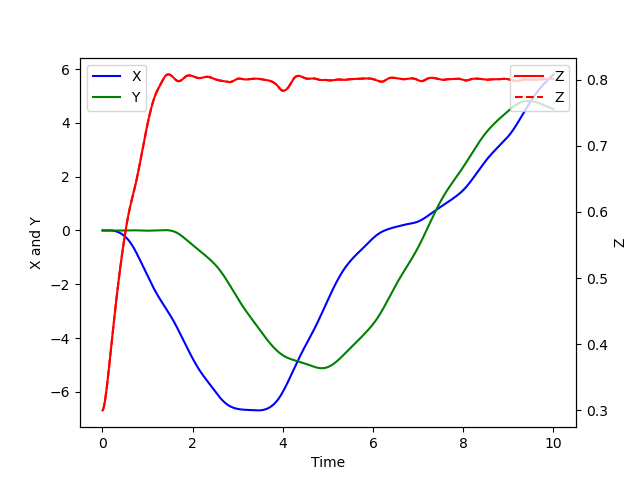

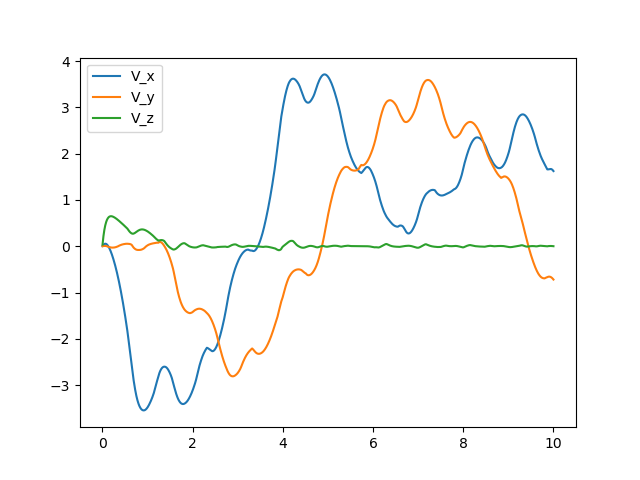

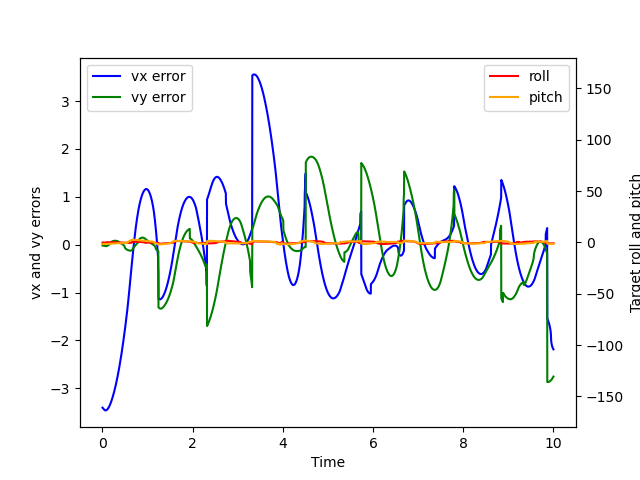

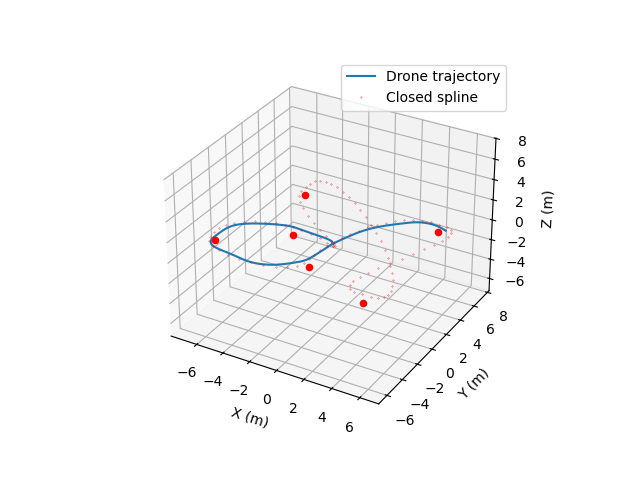

In [4]:
xml_path = dir_path + '/mujoco_menagerie-main/skydio_x2_racecourse/scene.xml'
drone = Drone(xml_path, n_gates=6)
drone.run_sim(10, 300, ctrl_type=CtrlType.FOLLOW_SPLINE, enable_camera=False)